# Using `checkplotserver` for a variable star classification project

This notebook walks through using the `hatlc`, `periodbase`, and `checkplot` modules to generate *checkplots* for a collection of light curves. These checkplots are either PNG images or Python pickle files containing all the period-finding, light curve, and object information. These are meant to be easy to share with collaborators, and for use in reviewing large collections of light curves. There are two methods of reviewing checkplots provided in `astrobase`:

- For small collections of light curves and for very cursory review, use the 3 x 3 plot grids produced by `checkplot.checkplot_png` for a single period-finding method, or use the 3 x 3 plot grids produced by `checkplot.twolsp_checkplot_png` for two independent period-finding methods applied to a single object. The notebook `lightcurve-work.ipynb` in this folder discusses this method.

- For much larger collections of light curves, and for detailed reviewing, use the `checkplot.checkplot_pickle` function to produce pickles containing object, period-finding, and variability information for multiple period-finding methods per object. These pickles can be reviewed by `checkplotserver`, a Tornado webapp provided as part of the `astrobase` package, and discussed in this notebook. This allows adding in and saving comments, best periods and epochs, object type tags, and variability type tags for each object in the collection. All information can then be exported to CSV or JSON.

Below, we'll go through:

- reading the light curves
- running period-finding on these light curves
- generating checkplot PNGs after period-finding is done
- some advanced options for checkplots
- generating checkplot pickles for a large variable classification project
- generating a file list for use with the `checkplotserver`
- reviewing objects, their light curves, and results of period-finding using the `checkplotserver`
- exporting all notes, tags, period and epoch information from the `checkplotserver` to CSV or JSON
- exporting individual object information to a PNG 

## Reading light curves

Most `astrobase` modules operate on magnitude time series observations. These can be extracted from your own light curves. At a minimum, the information required is:

- a numpy ndarray of `times`
- a numpy ndarray of `mags`
- a numpy ndarray of `errs` associated with each `mags`

If you have flux measurements instead of magnitudes, the functions in the `checkplot` module take a `magsarefluxes` keyword argument so all the plots and operations work correctly.

For this example, we'll use a collection of ten HAT survey light curves. These are in the "sqlitecurve" format and can be read, filtered, and normalized using the `astrobase.hatsurveys.hatlc` module.

In [4]:
cd ~/astrowork/astrobase-scratch/astrobase-notebook-lcs/

/Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs


In [5]:
ls *.sqlite.gz

HAT-133-0000968-V0-DR0-hatlc.sqlite.gz	HAT-772-0215246-V0-DR0-hatlc.sqlite.gz
HAT-186-0000088-V0-DR0-hatlc.sqlite.gz	HAT-772-0215592-V0-DR0-hatlc.sqlite.gz
HAT-228-0000237-V0-DR0-hatlc.sqlite.gz	HAT-772-0219865-V0-DR0-hatlc.sqlite.gz
HAT-314-0000816-V0-DR0-hatlc.sqlite.gz	HAT-772-0302504-V0-DR0-hatlc.sqlite.gz
HAT-553-0087416-V0-DR0-hatlc.sqlite.gz	HAT-772-0554686-V0-DR0-hatlc.sqlite.gz
HAT-579-0051858-V0-DR0-hatlc.sqlite.gz	HAT-772-0562164-V0-DR0-hatlc.sqlite.gz
HAT-772-0212353-V0-DR0-hatlc.sqlite.gz	HAT-777-0058978-V0-DR0-hatlc.sqlite.gz


In [1]:
# import the astrobase modules

# for reading HAT light curves
from astrobase.hatsurveys import hatlc

# for running period-finding on magnitude time-series observations
from astrobase import periodbase

# for generating checkplots to review object phased light curves, periods/epochs, and other info
from astrobase import checkplot

# import the Image module from IPython to embed images into the notebook
from IPython.display import Image

In [4]:
# here's how to read in a HAT sqlitecurve
lcd, msg = hatlc.read_and_filter_sqlitecurve('HAT-772-0554686-V0-DR0-hatlc.sqlite.gz')

In [5]:
# we can see all metadata using the hatlc.describe(lcdict) function
hatlc.describe(lcd)

OBJECT
------

objectid = HAT-772-0554686
hatid = HAT-772-0554686; twomassid = 14374811-5648595
network = HS; stations = HS02,HS04,HS06; ndet = 11261

ra = 219.450491; decl = -56.816551
pmra = 3.6; pmra_err = 2.9
pmdecl = -6.2; pmdecl_err = 2.9

jmag = 13.303; hmag = 12.65; kmag = 12.461; bmag = 17.744; vmag = 16.083
sdssg = 16.867; sdssr = 15.648; sdssi = 14.909

METADATA
--------

datarelease = 0; lcversion = 0
lastupdated = 1481860695.974; lcserver = e8980fa
comment = initial HS lightcurve creation
lcbestaperture = {"ap": ["002"], "ism": ["002"]}
lcsortcol = rjd
lcfiltersql = 
lcnormcols = 

CAMFILTERS
----------

7 - r - Sloan r AST0285
15 - r - Sloan r SN073 AST0285
23 - r - Sloan r SN081 AST0285

PHOTAPERTURES
-------------

000 - 2.05 px
001 - 3.00 px
002 - 4.00 px

LIGHT CURVE COLUMNS
-------------------

000 - rjd - time of observation in Reduced Julian date (JD = 2400000.0 + RJD)
001 - bjd - time of observation in Baryocentric Julian date (note: this is BJD_TDB)
002 - net - n

In [6]:
# we need times, magnitudes, and errors
# let's use RJD (the reduced Julian date = 2400000.0 - JD) for the times
# let's use the aperture photometry EPD (external parameter decorrelated) magnitude in aperture 000 (smallest) for mags
# let's use the instrumental mag error in aperture 000 as the errors
times, mags, errs = lcd['rjd'], lcd['aep_000'], lcd['aie_000']

In [7]:
# we can optionally normalize the magnitude time series observations to the global median
# this is useful for putting together light curves gathered from different instruments, filters, etc.
# for a single object, as is often the case for HAT survey light curves because we repeat observations in multiple seasons
normlcd = hatlc.normalize_lcdict(lcd)

/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
# get the normalized times, mags, errs as before. we'll use these going forward
ntimes, nmags, nerrs = normlcd['rjd'], normlcd['aep_000'], normlcd['aie_000']

## Running period-finding

The `astrobase.periodbase` contains several period finding methods that operate on `times`, `mags`, `errors` numpy ndarrays. If you can get these from your particular light curves, these methods should work successfully on them. In this case, we'll use these methods on the HAT light curve we read in above. The `periodbase` module contains the following period finding methods:

- Generalized Lomb-Scargle Periodogram (GLS; Zechmeister & Kurster 2009)
- Phase Dispersion Minimization (PDM; Stellingwerf 1978)
- Analysis of Variance (AoV; Schwarzenberg-Cerny 1989)
- Multi-harmonic Analysis of Variance (AoVMH; Schwarzenberg-Cerny 1996)
- Box-Least-Squares Fitting Search (BLS; Kovacs et al. 2002)
- Autocorrelation Function Period Search (ACF; McQuillan et al. 2014)

Using two or more of these on a single object can be a good way to check periodicity with independent methods. Below, we'll use the GLS, PDM, and BLS methods to see if the light curve we read in earlier has a periodic signal, and thus is from a variable star.

In [9]:
# run PDM on this light curve
# by default, the function will figure out a frequency grid automatically
# see the docstring for this function for details on how to set the start period, end period, and stepsize manually
pdm = periodbase.stellingwerf_pdm(ntimes, nmags, nerrs)

[2018-01-21T00:47:21Z - INFO] using autofreq with 41438 frequency points, start P = 0.100, end P = 828.843
[2018-01-21T00:47:21Z - INFO] using 8 workers...


In [10]:
# the resulting object is a dictionary (common in format across all periodbase period-finding methods)
pdm

{'bestlspval': 0.51601541296944564,
 'bestperiod': 3.0857895588235325,
 'kwargs': {'autofreq': True,
  'endp': None,
  'mindetperbin': 9,
  'nbestpeaks': 5,
  'normalize': False,
  'periodepsilon': 0.1,
  'phasebinsize': 0.05,
  'sigclip': 10.0,
  'startp': None,
  'stepsize': 0.0001},
 'lspvals': array([ 0.99402348,  0.99690486,  0.99847972, ...,  1.00105261,
         1.00085988,  1.00102471]),
 'method': 'pdm',
 'nbestlspvals': [0.51601541296944564,
  0.57264209249520126,
  0.67573477428737261,
  0.75443989234548581,
  0.77396494115972714],
 'nbestpeaks': 5,
 'nbestperiods': [3.0857895588235325,
  1.5428947794117662,
  6.1578237407132317,
  4.6304082430167641,
  7.7173470716946078],
 'periods': array([  8.28843076e+02,   6.90702563e+02,   5.92030768e+02, ...,
          1.00005197e-01,   1.00002784e-01,   1.00000371e-01])}

In [11]:
# the pdm['nbestperiods'] list contains the best five periods as determined from this method
pdm['nbestperiods']

[3.0857895588235325,
 1.5428947794117662,
 6.1578237407132317,
 4.6304082430167641,
 7.7173470716946078]

In [12]:
# the pdm['bestperiod'] value has the best period (in this case, with the smallest total dispersion)
pdm['bestperiod']

3.0857895588235325

In [13]:
# let's check this using another period-finding method: GLS
gls = periodbase.pgen_lsp(times,mags,errs)

[2018-01-21T00:47:42Z - INFO] using autofreq with 41438 frequency points, start P = 0.100, end P = 828.843
[2018-01-21T00:47:42Z - INFO] using 8 workers...


In [14]:
# the gls dict is in the same format as pdm earlier
gls

{'bestlspval': 0.16292453306373267,
 'bestperiod': 1.5428947794117664,
 'kwargs': {'autofreq': True,
  'endp': None,
  'nbestpeaks': 5,
  'periodepsilon': 0.1,
  'sigclip': 10.0,
  'startp': None,
  'stepsize': 0.0001},
 'lspvals': array([ 0.00253153,  0.00077572,  0.00058094, ...,  0.00012392,
         0.00012962,  0.00010454]),
 'method': 'gls',
 'nbestlspvals': [0.16292453306373267,
  0.089798983115883482,
  0.062605571343796129,
  0.057582441673335594,
  0.027127022400479581],
 'nbestpeaks': 5,
 'nbestperiods': [1.5428947794117664,
  0.77130381118555824,
  0.51423444316912825,
  3.0857895588235329,
  0.38547254929774016],
 'omegas': array([  7.58066936e-03,   9.09680323e-03,   1.06129371e-02, ...,
          6.28285877e+01,   6.28301038e+01,   6.28316199e+01]),
 'periods': array([  8.28843076e+02,   6.90702563e+02,   5.92030768e+02, ...,
          1.00005197e-01,   1.00002784e-01,   1.00000371e-01])}

In [15]:
# the best periods don't appear to entirely agree, however
gls['nbestperiods']

[1.5428947794117664,
 0.77130381118555824,
 0.51423444316912825,
 3.0857895588235329,
 0.38547254929774016]

In [16]:
# let's run another period finding method to make sure: BLS
# let's restrict the start period to 1.0 days to save some time
bls = periodbase.bls_parallel_pfind(times,mags,errs,startp=1.0)

[2018-01-21T00:47:56Z - INFO] autofreq: using stepsize: 3.01625250171e-06, min P: 1.0, max P: 100.0, nfreq: 328222, nphasebins: 200, min transit duration: 0.01, max transit duration: 0.8
[2018-01-21T00:47:56Z - INFO] autofreq: minfreq: 0.01, maxfreq: 1.0
[2018-01-21T00:47:56Z - INFO] using 8 workers...
[2018-01-21T00:47:56Z - INFO] worker 1: minfreq = 0.010, nfreqs = 41028
[2018-01-21T00:47:56Z - INFO] worker 2: minfreq = 0.134, nfreqs = 41028
[2018-01-21T00:47:56Z - INFO] worker 3: minfreq = 0.258, nfreqs = 41028
[2018-01-21T00:47:56Z - INFO] worker 4: minfreq = 0.381, nfreqs = 41028
[2018-01-21T00:47:56Z - INFO] worker 5: minfreq = 0.505, nfreqs = 41028
[2018-01-21T00:47:56Z - INFO] worker 6: minfreq = 0.629, nfreqs = 41028
[2018-01-21T00:47:56Z - INFO] worker 7: minfreq = 0.753, nfreqs = 41028
[2018-01-21T00:47:56Z - INFO] worker 8: minfreq = 0.876, nfreqs = 41026
[2018-01-21T00:47:56Z - INFO] running...


In [18]:
# let's see the best periods list
bls['nbestperiods']

[3.0856065504766148,
 1.5427700518091203,
 6.171306589669304,
 9.2565832017969942,
 4.6283156559753316]

This looks like an eclipsing binary; the GLS method usually finds a harmonic associated with the actual period. We need a way to incorporate all of these period-finding methods into a review method so we can decided what looks right for this object. For this, we'll turn to the checkplot module.

## Making checkplot PNGs

Since this is a single object, we could just use the `checkplot.checkplot_png` function along with one of the `gls`, `pdm`, or `bls` dicts above to generate PNGs for review. But these are hard to add notes to if we're reviewing lots of them. 

Let's make a checkplot PNG anyway, just for visualization's sake, using the `checkplot.twolsp_checkplot_png` function to see two period-finding methods applied to this object at once. We'll make a checkplot pickle for this object later, along with those for all other objects in this ensemble. We'll be able to review all of these quickly using the `checkplotserver` webapp.

In [19]:
# make a checkplot PNG of this object. we'll use the twolsp_checkplot_png function
# because we want to compare two period-finding methods and see if they give us
# the same best period.
# the objectinfo keyword argument allows us to add in extra info so we can
# get a nice finder chart if objectid, ra, decl are provided, and 
# magnitudes, colors, and proper motions are provided. the HAT light curves
# come with these included, so let's just pass that dict in
cpf = checkplot.twolsp_checkplot_png(pdm, bls, ntimes, nmags, nerrs, objectinfo=lcd['objectinfo'])

[2018-01-21T00:48:27Z - INFO] adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817
[2018-01-21T00:48:27Z - INFO] fetched stamp successfully for (219.450, -56.817)
[2018-01-21T00:48:27Z - INFO] spline fit done. nknots = 30,  chisq = 20684.76565, reduced chisq = 1.96362
[2018-01-21T00:48:27Z - INFO] plotting phased LC with period 3.085790, epoch 56794.68388
[2018-01-21T00:48:28Z - INFO] plotting phased LC with period 1.542895, epoch 56794.68388
[2018-01-21T00:48:28Z - INFO] plotting phased LC with period 6.157824, epoch 56794.68388
[2018-01-21T00:48:29Z - INFO] plotting phased LC with period 3.085607, epoch 56794.68388
[2018-01-21T00:48:30Z - INFO] plotting phased LC with period 1.542770, epoch 56794.68388
[2018-01-21T00:48:30Z - INFO] plotting phased LC with period 6.171307, epoch 56794.68388


/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


[2018-01-21T00:48:34Z - INFO] checkplot done -> twolsp-checkplot.png


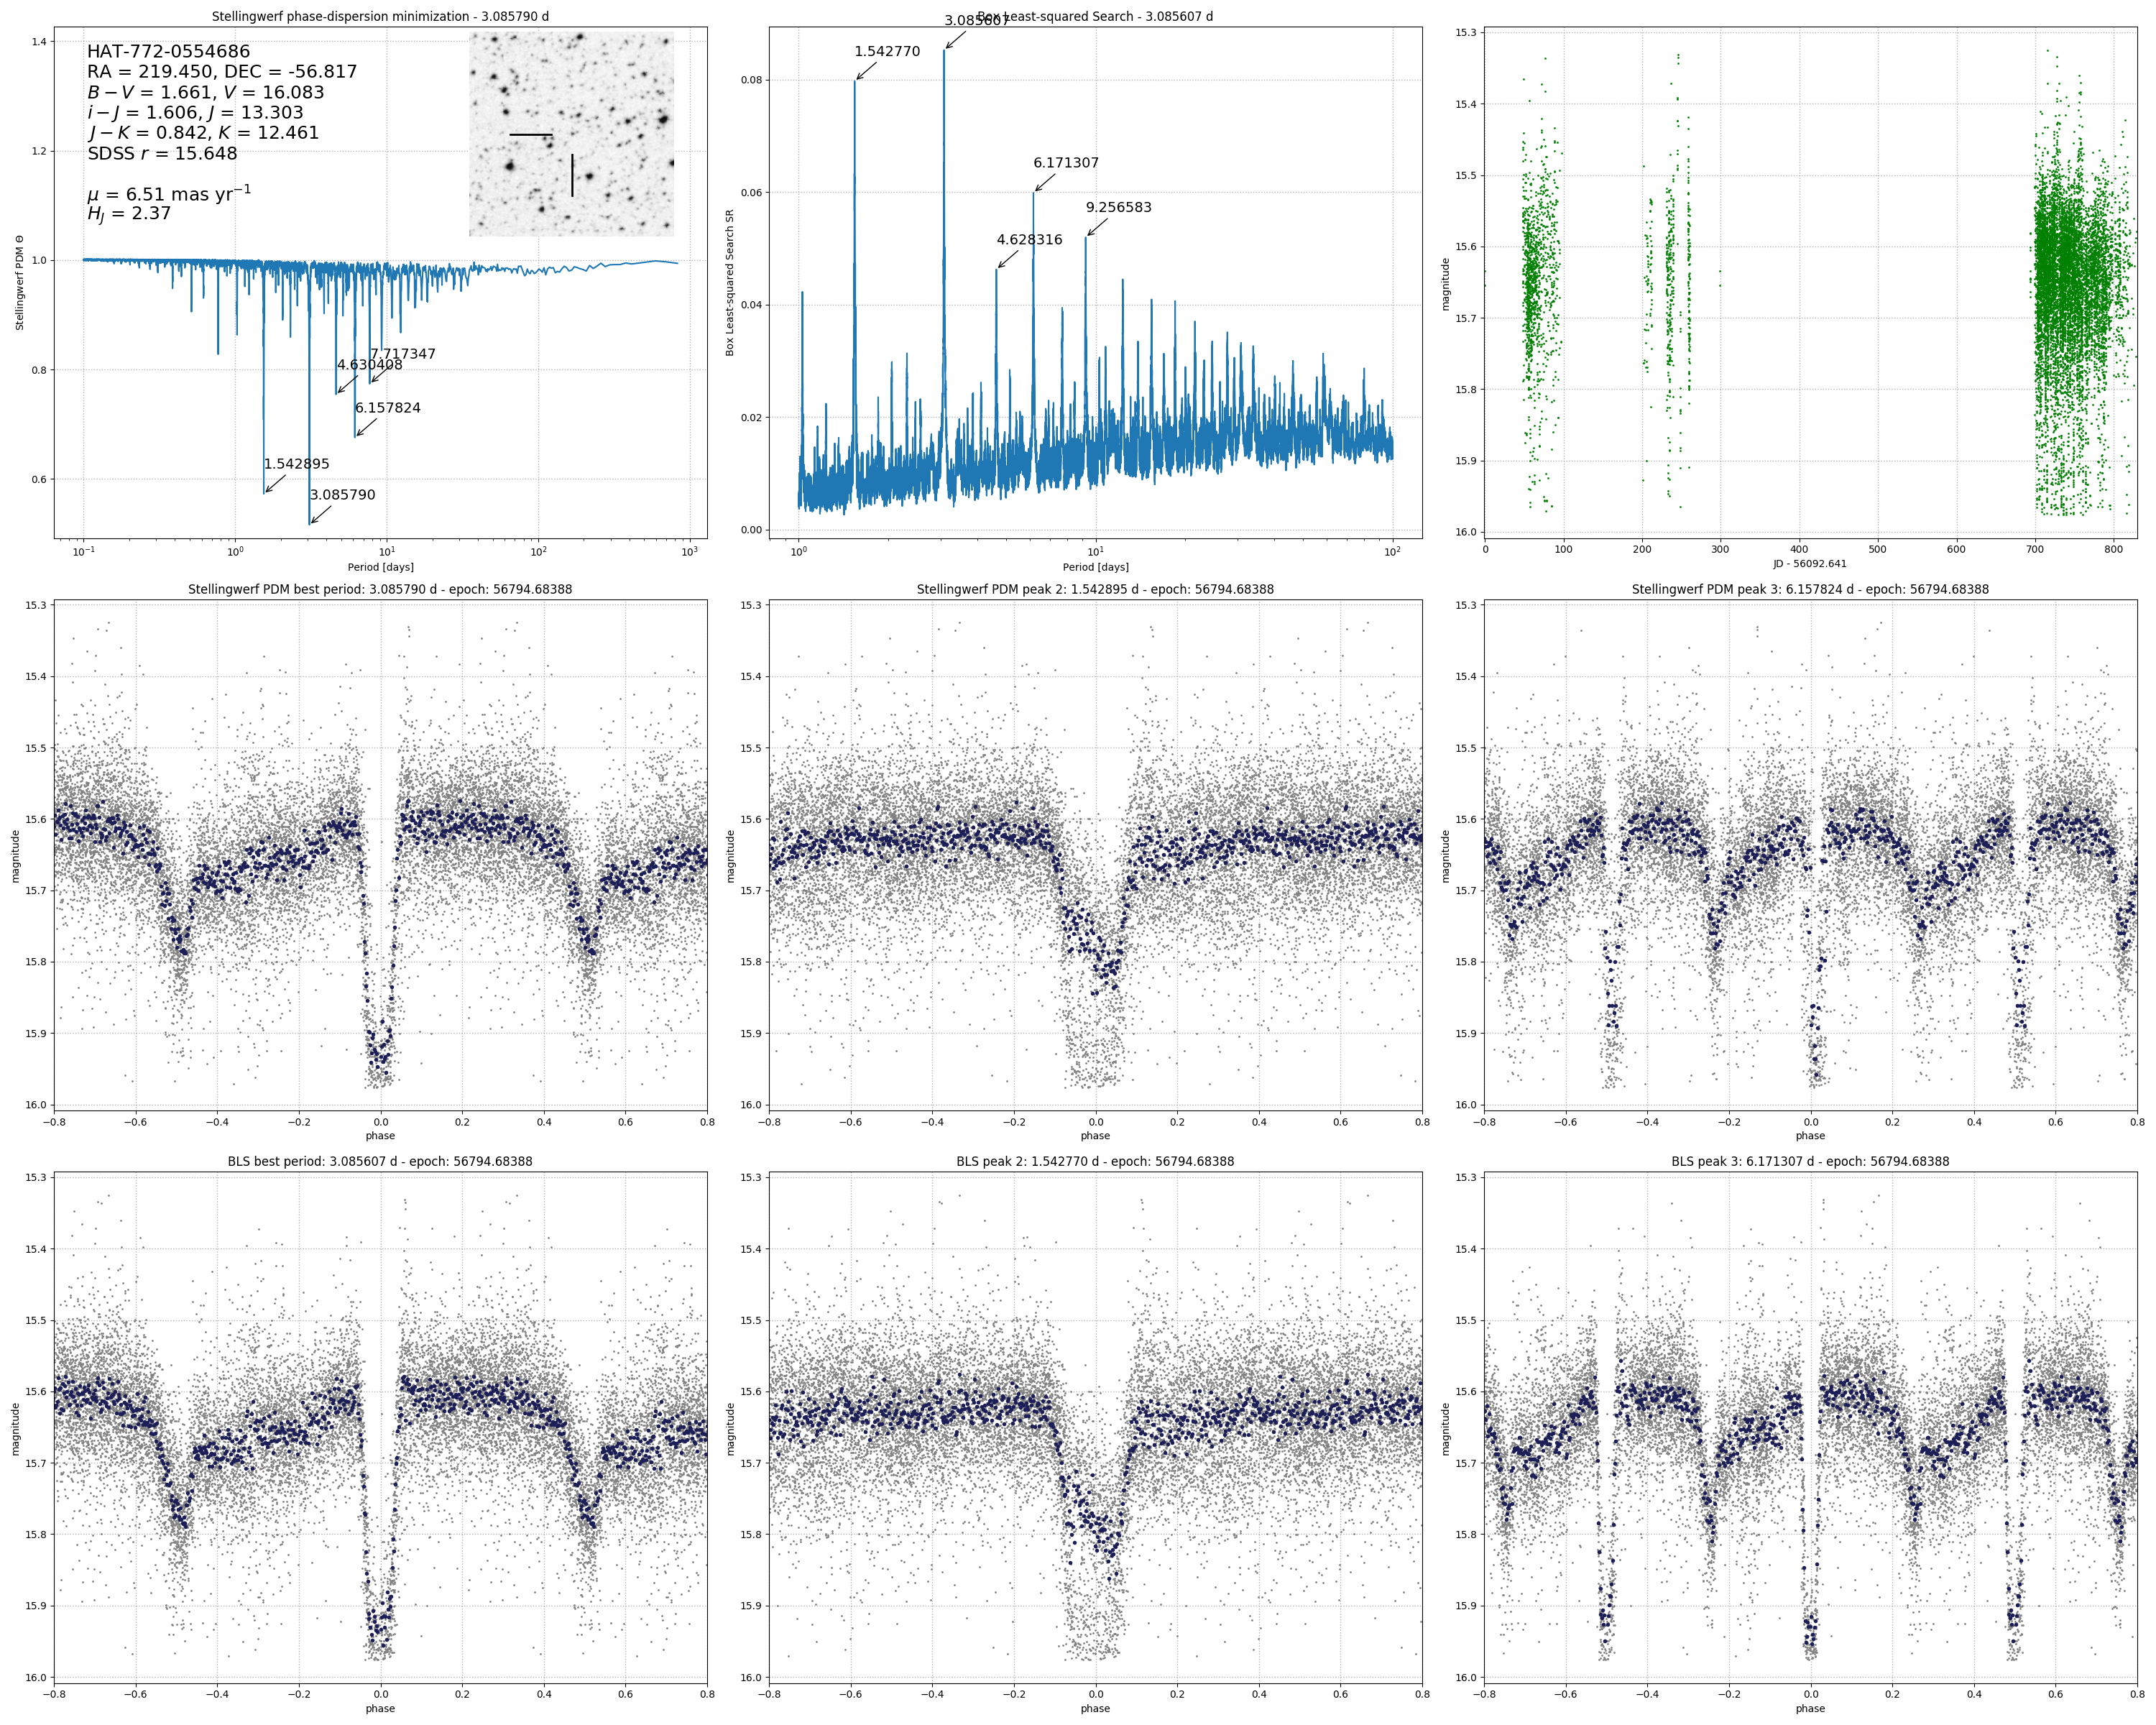

In [20]:
# let's look at this checkplot
Image('twolsp-checkplot.png')

That looks like a promising eclipsing binary. Let's zoom in on the primary eclipse. The `xliminsetmode` and `plotxlim` keywords will do this for us. 

In [21]:
cpf = checkplot.twolsp_checkplot_png(pdm, bls, ntimes, nmags, nerrs, objectinfo=lcd['objectinfo'],
                                     xliminsetmode=True, plotxlim=[-0.2,0.2])

[2018-01-21T00:48:39Z - INFO] adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817
[2018-01-21T00:48:39Z - INFO] fetched stamp successfully for (219.450, -56.817)
[2018-01-21T00:48:40Z - INFO] spline fit done. nknots = 30,  chisq = 20684.76565, reduced chisq = 1.96362
[2018-01-21T00:48:40Z - INFO] plotting phased LC with period 3.085790, epoch 56794.68388
[2018-01-21T00:48:40Z - INFO] plotting phased LC with period 1.542895, epoch 56794.68388
[2018-01-21T00:48:41Z - INFO] plotting phased LC with period 6.157824, epoch 56794.68388
[2018-01-21T00:48:41Z - INFO] plotting phased LC with period 3.085607, epoch 56794.68388
[2018-01-21T00:48:42Z - INFO] plotting phased LC with period 1.542770, epoch 56794.68388
[2018-01-21T00:48:43Z - INFO] plotting phased LC with period 6.171307, epoch 56794.68388


/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


[2018-01-21T00:48:46Z - INFO] checkplot done -> twolsp-checkplot.png


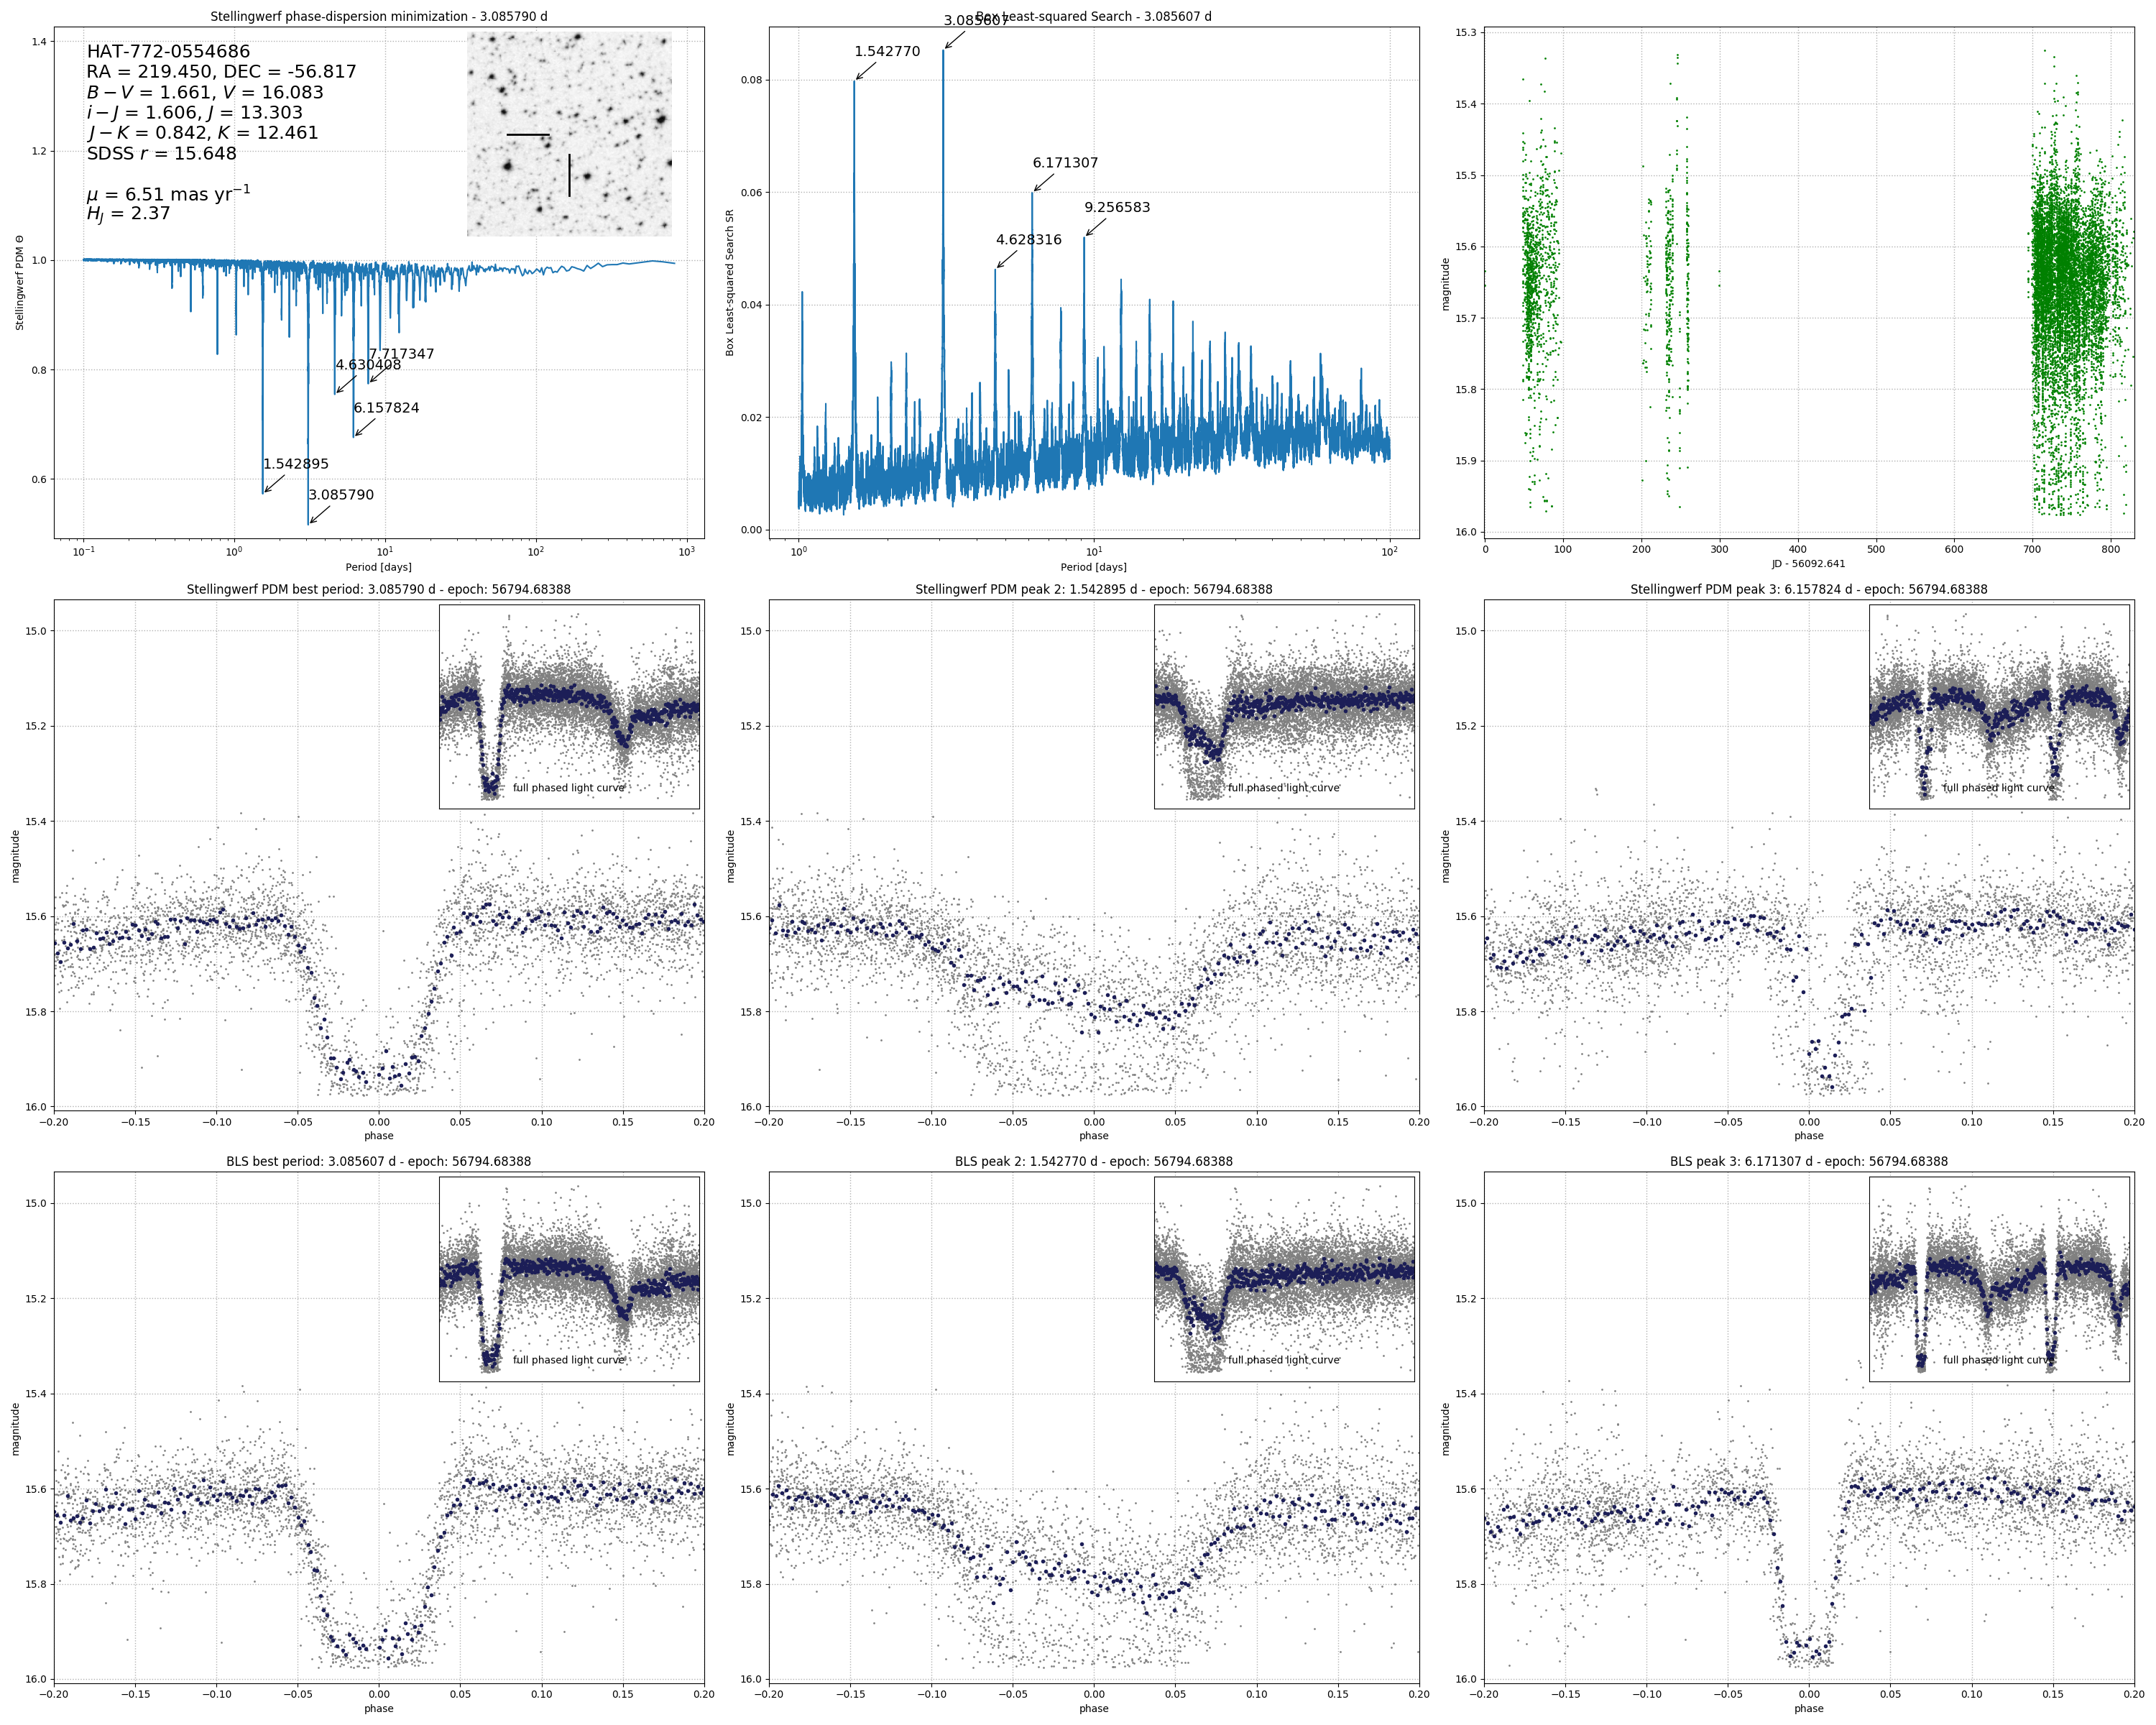

In [22]:
# let's see the new checkplot
Image('twolsp-checkplot.png')

Now the primary eclipse is the main feature of the plot. This is especially useful for transit searches.

The same keyword arguments can be used across all checkplot functions: `checkplot_png`, `twolsp_checkplot_png`, and `checkplot_pickle`. 

## Making checkplot pickles

Checkplot pickles are the format to use if you want to work on lots of light curves. They can be reviewed easily using the `checkplotserver` app and contain all light curve data that was used to generate them, all periodogram data, all variability tags, periods, epochs, and all object information, including tags, magnitudes, colors, proper motions, and comments. They also include results from an arbitrary number of period-finding methods. Finally, all plots and object information in a checkplot pickle can be exported to a PNG similar to that produced by the `*_checkplot_png` functions discussed above.

In [23]:
# let's make a checkplot pickle for this object.
# the inputs are a list of results from the period-finding methods above; the times, mags, and errs arrays; and 
# the objectinfo dict from the HAT light curve. see the docstring for this function to see what this should look
# like for your own light curves. at a minimum: an objectid (a string), and the object's right ascension and declination
# are required to generate a finding chart. this is entirely optional, so leave it out if you don't want one.
# let's use the xliminsetmode and 
cpf = checkplot.checkplot_pickle([gls,pdm,bls], 
                                 times, mags, errs, 
                                 objectinfo=lcd['objectinfo'], 
                                 outfile='checkplot-%s.pkl' % lcd['objectid'],
                                 xliminsetmode=True, plotxlim=[-0.2,0.2])

[2018-01-21T00:48:57Z - INFO] adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817
[2018-01-21T00:48:58Z - INFO] fetched stamp successfully for (219.450, -56.817)
[2018-01-21T00:48:58Z - INFO] sigclip = 4.0: before = 11261 observations, after = 10557 observations
[2018-01-21T00:48:58Z - INFO] spline fit done. nknots = 30,  chisq = 26529.82266, reduced chisq = 2.52041
[2018-01-21T00:48:58Z - INFO] plotting gls phased LC with period 0: 1.542895, epoch: 56341.11968
[2018-01-21T00:48:59Z - INFO] spline fit done. nknots = 30,  chisq = 37232.27218, reduced chisq = 3.53717
[2018-01-21T00:48:59Z - INFO] plotting gls phased LC with period 1: 0.771304, epoch: 56856.46618
[2018-01-21T00:49:00Z - INFO] spline fit done. nknots = 30,  chisq = 38898.07011, reduced chisq = 3.69543
[2018-01-21T00:49:00Z - INFO] plotting gls phased LC with period 2: 0.514234, epoch: 56889.88470
[2018-01-21T00:49:01Z - INFO] spline fit done. nknots = 30,  chisq = 20319.24636, red

In [24]:
# the output pickle now contains a dict with all of the useful info
# we can read this in if needed
cpdict = checkplot._read_checkplot_picklefile(cpf)

In [25]:
# look at the keys of the dict
cpdict.keys()

dict_keys(['objectid', 'neighbors', 'objectinfo', 'finderchart', 'sigclip', 'normto', 'normmingap', 'varinfo', 'magseries', 'gls', 'pdm', 'bls', 'comments', 'signals', 'externalplots', 'status'])

In [26]:
# some details for the object
cpdict['objectinfo']

{'bmag': 17.744,
 'bmagfromjhk': False,
 'bvcolor': 0.23900000000000077,
 'closestdistarcsec': nan,
 'closestdistnbrind': array([], dtype=float64),
 'color_classes': ['WD/sdO/sdB'],
 'd_gr': 0.050252939999994362,
 'd_ug': -1.5332968000000085,
 'decl': -56.816551,
 'deredb': 12.343,
 'dereddened': True,
 'deredg': 11.967000000000001,
 'deredh': 11.968,
 'deredi': 12.390000000000001,
 'deredj': 12.23,
 'deredk': 12.000999999999999,
 'deredr': 12.257999999999999,
 'deredu': 11.698673199999991,
 'deredv': 12.103999999999999,
 'deredz': 12.633898,
 'distarcsec': array([], dtype=float64),
 'extinctb': 5.4009999999999998,
 'extinctg': 4.9000000000000004,
 'extincth': 0.68200000000000005,
 'extincti': 2.5190000000000001,
 'extinctj': 1.073,
 'extinctk': 0.46000000000000002,
 'extinctr': 3.3900000000000001,
 'extinctu': 6.2880000000000003,
 'extinctv': 3.9790000000000001,
 'extinctz': 1.8740000000000001,
 'gaia_closest_distarcsec': 7.3144285163756155,
 'gaia_closest_gmagdiff': -1.19667196940612

In [27]:
# some variability information, which currently only contains basic star features and no comments, 
# periods, epochs, or object/variable type tags since we haven't reviewed this object yet
cpdict['varinfo']

{'features': {'amplitude': 0.326295,
  'beyond1std': 0.32821824381926684,
  'eta_normal': 0.97294487330868396,
  'eta_robust': 0.00080362461404198031,
  'eta_uneven_normal': 5745304702598.8398,
  'eta_uneven_robust': 592750845884.67212,
  'flux_median': 8.5978130969743674e-07,
  'flux_percent_amplitude': 1.3422147280611161,
  'flux_percentile_ratio_mid20': 0.1309231246779255,
  'flux_percentile_ratio_mid35': 0.23566220599670001,
  'flux_percentile_ratio_mid50': 0.35271240387424529,
  'flux_percentile_ratio_mid65': 0.49772071004189355,
  'flux_percentile_ratio_mid80': 0.71872826603906115,
  'flux_percentiles': array([  7.18413360e-07,   7.61987067e-07,   7.94302629e-07,
           8.14250436e-07,   8.30101885e-07,   8.43484682e-07,
           8.74557563e-07,   8.86033209e-07,   8.97962086e-07,
           9.12430092e-07,   9.32567767e-07,   9.55750205e-07]),
  'kurtosis': 1.2528189599584998,
  'linear_fit_slope': 15.361156334414883,
  'mad': 0.052065000000000694,
  'mag_iqr': 0.106249999

In [28]:
# let's export the checkplot to a PNG for quick visualization
# the input is either a checkplot dict read in by _read_checkplot_picklefile
# or the filename of the checkplot pickle
# 
cpfpng = checkplot.checkplot_pickle_to_png(cpdict, 'checkplot-pickle.png')

[2018-01-21T00:49:19Z - INFO] checkplot pickle -> checkplot PNG: checkplot-pickle.png OK


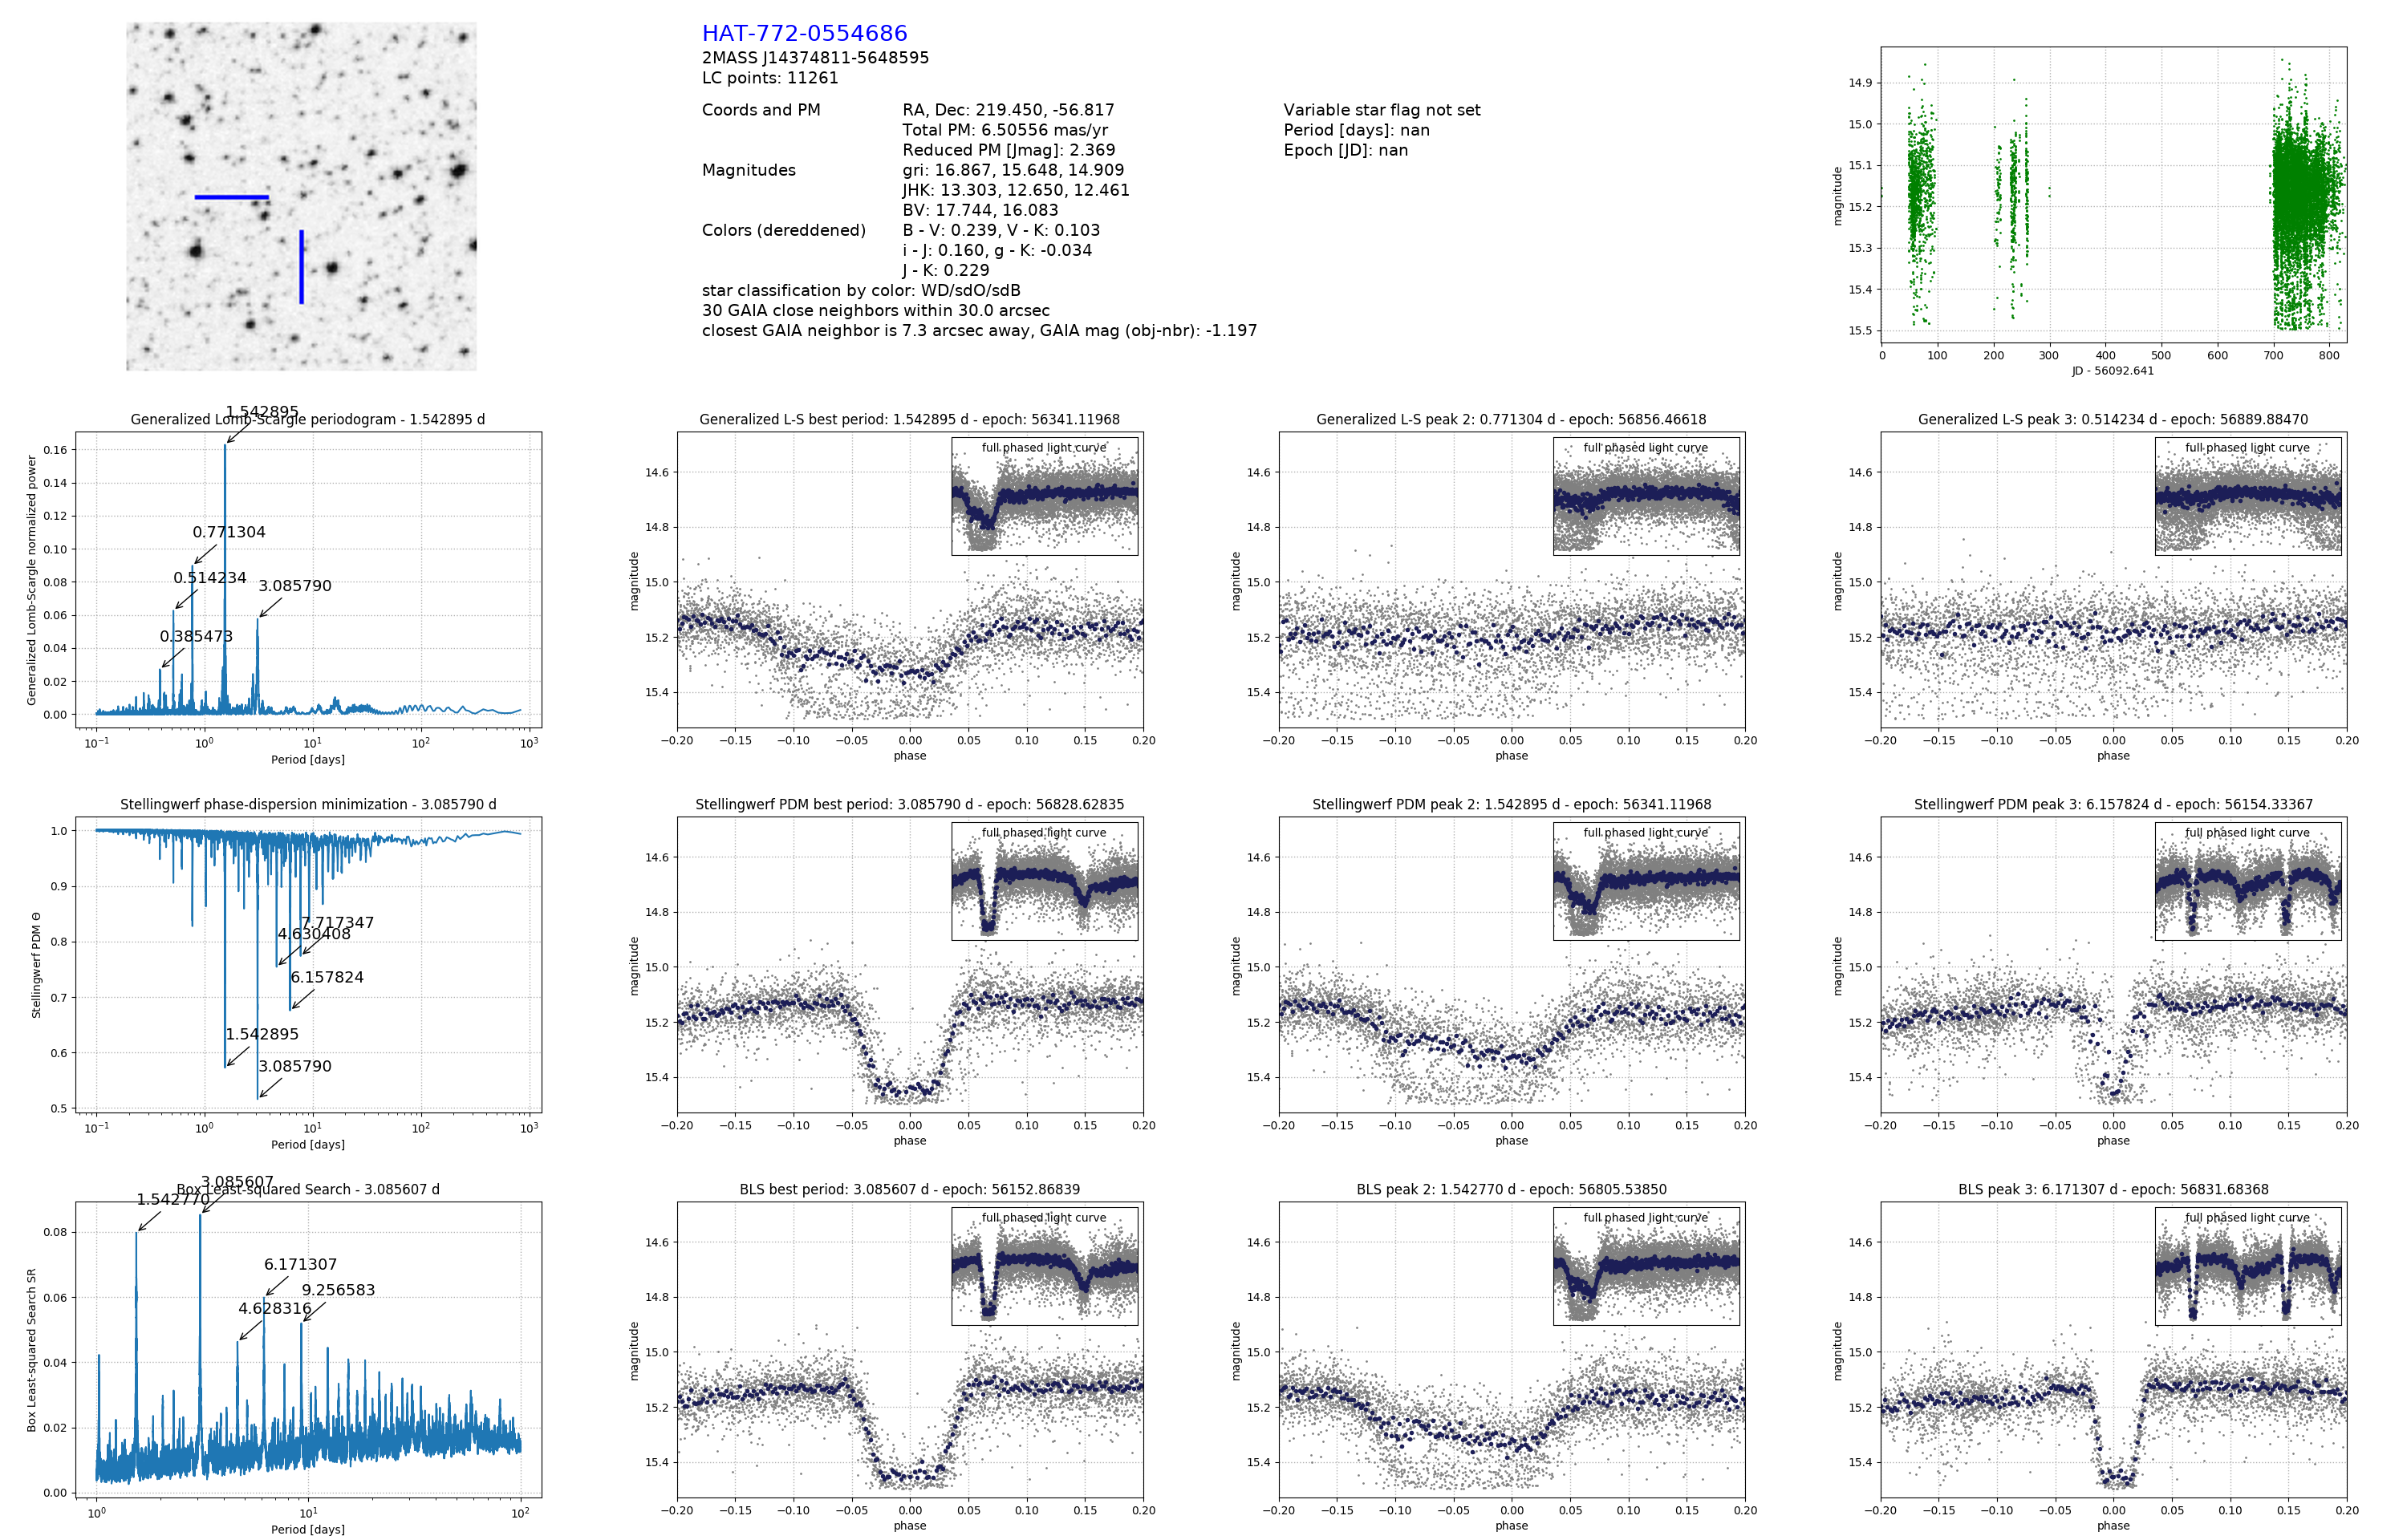

In [29]:
# let's see this exported PNG
Image('checkplot-pickle.png')

This PNG now contains all the information that the checkplot pickle contained, including any comments, changes to the best period and epoch, as well as variability and object type tags. 

## Working on many light curves

Now that we have made a checkplot pickle for a single object, we can repeat it for the rest of the light curves in our collection. The `lcproc` module in the `astrobase` package contains functions to do this. These functions can be adopted to any light curve format, given a provided light curve reader function. To register a function for reading your light curve format, use the `lcproc.register_custom_lcformat` function:

```python
def register_custom_lcformat(formatkey,
                             fileglob,
                             readerfunc,
                             timecols,
                             magcols,
                             errcols,
                             magsarefluxes=False,
                             specialnormfunc=None):
```

Here, the parameters are:

- `formatkey`: a string that can be used to refer to the LC format by all `lcproc` functions
- `fileglob`: a string that defines the filename search string to find LC files (e.g. `HAT-*sqlite.gz` for HAT light curves)
- `readerfunc`: a Python function to read the the light curve and return a dict with columns and object info: an 'lcdict'
- `timecols`: a list of lcdict keys that contain the time values for the light curve.
- `magcols`: a list of lcdict keys that contain the magnitude/flux values for the light curve. Multiple apertures, etc. can be processed by `lcproc` functions if they are in separate magcol keys of the lcdict.
- `errcols`: a list of lcdict keys that contain the measurement errors for each magcol
- `magsarefluxes`: can be set to True if the magcols actually contain flux values; this makes plots, sigma-clipping, etc. work correctly for fluxes.
- `specialnormfunc`: a Python function to normalize the times, mags, errs in some special way. Most `lcproc` functions will normalize the mag/flux values to their median before processing. If this needs to be done in some special way (e.g. handling different offset values between measurement eras), provide a function to do so here.

See the docstring for the `register_custom_lcformat` function for much more detail on these parameters.

For now, we'll just use the built-in support for HAT survey light curves in `lcproc`.

In [2]:
from astrobase import lcproc

We'll use the `lcproc.parallel_pf_lcdir` function to run various period-finders on all light curves in a single directory.

```python
def parallel_pf_lcdir(lcdir,
                      outdir,
                      recursive=True,
                      timecols=None,
                      magcols=None,
                      errcols=None,
                      lcformat='hat-sql',
                      pfmethods=['gls','pdm','mav','win'],
                      pfkwargs=[{},{},{},{}],
                      getblssnr=False,
                      sigclip=10.0,
                      nperiodworkers=10,
                      ncontrolworkers=4,
                      liststartindex=None,
                      listmaxobjects=None,
                      excludeprocessed=True):

```

In [6]:
pwd

'/Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs'

In [7]:
ls *.sqlite.gz

HAT-133-0000968-V0-DR0-hatlc.sqlite.gz	HAT-772-0215246-V0-DR0-hatlc.sqlite.gz
HAT-186-0000088-V0-DR0-hatlc.sqlite.gz	HAT-772-0215592-V0-DR0-hatlc.sqlite.gz
HAT-228-0000237-V0-DR0-hatlc.sqlite.gz	HAT-772-0219865-V0-DR0-hatlc.sqlite.gz
HAT-314-0000816-V0-DR0-hatlc.sqlite.gz	HAT-772-0302504-V0-DR0-hatlc.sqlite.gz
HAT-553-0087416-V0-DR0-hatlc.sqlite.gz	HAT-772-0554686-V0-DR0-hatlc.sqlite.gz
HAT-579-0051858-V0-DR0-hatlc.sqlite.gz	HAT-772-0562164-V0-DR0-hatlc.sqlite.gz
HAT-772-0212353-V0-DR0-hatlc.sqlite.gz	HAT-777-0058978-V0-DR0-hatlc.sqlite.gz


Let's run `lcproc.parallel_pf_lcdir` on these light curves. This will produce `periodfinding-*.pkl` files that contain the results. These can then be fed into the next stage of our pipeline.

In [33]:
pfr = lcproc.parallel_pf_lcdir('.',
                               '.',
                               pfmethods=['gls','pdm'], # to save time
                               nperiodworkers=8,
                               ncontrolworkers=1,
                               listmaxobjects=6) # to save time          

[2018-01-21T00:52:08Z - INFO] searching for hat-sql light curves in . ...
[2018-01-21T00:52:08Z - INFO] found 14 light curves, running pf...
[2018-01-21T00:52:09Z - WRN!] no sdssr available in lcdict, normalizing to 0.0
[2018-01-21T00:52:35Z - WRN!] no sdssr available in lcdict, normalizing to 0.0
[2018-01-21T00:53:37Z - WRN!] no sdssr available in lcdict, normalizing to 0.0


In [9]:
# all done!
!ls periodfinding*.pkl

periodfinding-HAT-133-0000968.pkl  periodfinding-HAT-314-0000816.pkl
periodfinding-HAT-186-0000088.pkl  periodfinding-HAT-553-0087416.pkl
periodfinding-HAT-228-0000237.pkl  periodfinding-HAT-579-0051858.pkl


Let's look inside one of these pickles.

In [35]:
import pickle

with open('periodfinding-HAT-579-0051858.pkl','rb') as infd:
    pf = pickle.load(infd)

In [37]:
# the result is a dict with results for each magnitude column specified
pf.keys()

dict_keys(['objectid', 'lcfbasename', 'kwargs', 'aep_000', 'atf_000'])

In [38]:
# each magcol key contains the results from each period finder
pf['aep_000'].keys()

dict_keys(['gls', 'pdm'])

In [40]:
# these are the usual periodfinder result dicts we saw earlier
pf['aep_000']['gls']

{'bestlspval': 0.0029363040292567327,
 'bestperiod': 19.63210969382018,
 'kwargs': {'autofreq': True,
  'endp': None,
  'nbestpeaks': 5,
  'periodepsilon': 0.1,
  'sigclip': 10.0,
  'startp': None,
  'stepsize': 0.0001},
 'lspvals': array([  4.21938297e-06,   1.50556009e-04,   1.73925349e-04, ...,
          2.26196648e-04,   2.00883995e-04,   1.77951548e-04]),
 'method': 'gls',
 'nbestlspvals': [0.0029363040292567327,
  0.0028205116114527187,
  0.0027539384886288588,
  0.0027077761516469965,
  0.0026789119325445862],
 'nbestpeaks': 5,
 'nbestperiods': [19.63210969382018,
  19.743025567796565,
  19.522433103351908,
  20.316950729651115,
  20.199511708092437],
 'omegas': array([  8.99006638e-03,   1.07880797e-02,   1.25860929e-02, ...,
          6.28279779e+01,   6.28297759e+01,   6.28315739e+01]),
 'periods': array([  6.98903105e+02,   5.82419254e+02,   4.99216504e+02, ...,
          1.00006168e-01,   1.00003306e-01,   1.00000444e-01])}

The next step is to visualize all of these results using checkplots. `lcproc` provides the `parallel_cp_pfdir` function to make these:

```python
def parallel_cp_pfdir(pfpickledir,
                      outdir,
                      lcbasedir,
                      lclistpkl=None,
                      nbrradiusarcsec=30.0,
                      xmatchinfo=None,
                      xmatchradiusarcsec=3.0,
                      sigclip=10.0,
                      maxobjects=None,
                      pfpickleglob='periodfinding-*.pkl*',
                      lcformat='hat-sql',
                      timecols=None,
                      magcols=None,
                      errcols=None,
                      nworkers=32):
```

Let's generate our checkplots now.

In [10]:
cps = lcproc.parallel_cp_pfdir('.','.','.',nworkers=2)

[2018-01-21T01:06:15Z - INFO] found 6 period-finding pickles, running cp...


/Users/waqasbhatti/mycode/astrobase/astrobase/coordutils.py:364: RuntimeWarning: divide by zero encountered in log10
  rpm = jmag + 5.0*np.log10(propermotion/1000.0)


[2018-01-21T01:06:22Z - EXC!] spline fit failed, using min(times) as epoch
exception was: Traceback (most recent call last):
  File "/Users/waqasbhatti/mycode/astrobase/astrobase/checkplot.py", line 1835, in _pkl_phased_magseries_plot
    verbose=verbose)
  File "/Users/waqasbhatti/mycode/astrobase/astrobase/varbase/lcfit.py", line 570, in spline_fit_magseries
    spl = LSQUnivariateSpline(phase,pmags,t=splineknots,w=1.0/perrs)
  File "/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py", line 738, in __init__
    raise ValueError('x must be strictly increasing')
ValueError: x must be strictly increasing

[2018-01-21T01:06:22Z - EXC!] spline fit failed, using min(times) as epoch
exception was: Traceback (most recent call last):
  File "/Users/waqasbhatti/mycode/astrobase/astrobase/checkplot.py", line 1835, in _pkl_phased_magseries_plot
    verbose=verbose)
  File "/Users/waqasbhatti/mycode/astrobase/astrobase/varbase/lcfit.py", line 570, in spline_fit


[2018-01-21T01:06:28Z - ERR!] no neighbors for HAT-133-0000968, not updating...
[2018-01-21T01:06:28Z - INFO] done with HAT-133-0000968 -> ['/Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs/checkplot-HAT-133-0000968-aep_000.pkl', '/Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs/checkplot-HAT-133-0000968-atf_000.pkl']
[2018-01-21T01:06:29Z - EXC!] spline fit failed, using min(times) as epoch
exception was: Traceback (most recent call last):
  File "/Users/waqasbhatti/mycode/astrobase/astrobase/checkplot.py", line 1835, in _pkl_phased_magseries_plot
    verbose=verbose)
  File "/Users/waqasbhatti/mycode/astrobase/astrobase/varbase/lcfit.py", line 570, in spline_fit_magseries
    spl = LSQUnivariateSpline(phase,pmags,t=splineknots,w=1.0/perrs)
  File "/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py", line 738, in __init__
    raise ValueError('x must be strictly increasing')
ValueError: x must be strictly i


[2018-01-21T01:06:42Z - EXC!] spline fit failed, using min(times) as epoch
exception was: Traceback (most recent call last):
  File "/Users/waqasbhatti/mycode/astrobase/astrobase/checkplot.py", line 1835, in _pkl_phased_magseries_plot
    verbose=verbose)
  File "/Users/waqasbhatti/mycode/astrobase/astrobase/varbase/lcfit.py", line 570, in spline_fit_magseries
    spl = LSQUnivariateSpline(phase,pmags,t=splineknots,w=1.0/perrs)
  File "/Users/waqasbhatti/py36-venv/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py", line 738, in __init__
    raise ValueError('x must be strictly increasing')
ValueError: x must be strictly increasing

[2018-01-21T01:06:42Z - EXC!] spline fit failed, using min(times) as epoch
exception was: Traceback (most recent call last):
  File "/Users/waqasbhatti/mycode/astrobase/astrobase/checkplot.py", line 1835, in _pkl_phased_magseries_plot
    verbose=verbose)
  File "/Users/waqasbhatti/mycode/astrobase/astrobase/varbase/lcfit.py", line 570, in spline_fi


[2018-01-21T01:07:00Z - ERR!] no neighbors for HAT-553-0087416, not updating...
[2018-01-21T01:07:00Z - INFO] done with HAT-553-0087416 -> ['/Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs/checkplot-HAT-553-0087416-aep_000.pkl', '/Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs/checkplot-HAT-553-0087416-atf_000.pkl']
[2018-01-21T01:07:01Z - ERR!] no neighbors for HAT-579-0051858, not updating...
[2018-01-21T01:07:01Z - INFO] done with HAT-579-0051858 -> ['/Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs/checkplot-HAT-579-0051858-aep_000.pkl', '/Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs/checkplot-HAT-579-0051858-atf_000.pkl']


In [11]:
# should be done, despite the scary messages above
!ls checkplot*.pkl

checkplot-HAT-133-0000968-aep_000.pkl  checkplot-HAT-314-0000816-atf_000.pkl
checkplot-HAT-133-0000968-atf_000.pkl  checkplot-HAT-553-0087416-aep_000.pkl
checkplot-HAT-186-0000088-aep_000.pkl  checkplot-HAT-553-0087416-atf_000.pkl
checkplot-HAT-186-0000088-atf_000.pkl  checkplot-HAT-579-0051858-aep_000.pkl
checkplot-HAT-228-0000237-aep_000.pkl  checkplot-HAT-579-0051858-atf_000.pkl
checkplot-HAT-228-0000237-atf_000.pkl  checkplot-HAT-772-0554686.pkl
checkplot-HAT-314-0000816-aep_000.pkl


Looks good.

Now that we're done with period-finding and making checkplots, we can go ahead and visualize the results using the `checkplotserver` web app.

## Using the `checkplotserver` for a collection of light curves

Once you've made all the checkplots for all the light curves in your collection, you can review all of them using the `checkplotserver`. 

Before the `checkplotserver` webapp can work on your collection of light curves, it needs to know where all the checkplot pickles you produced are. We use the `checkplotlist` script to generate a JSON file for this purpose.

In [13]:
# basic help for the checkplotlist script. this comes with astrobase and should be on your path
!checkplotlist 

usage: checkplotlist [-h] [--search SEARCH] [--sortby SORTBY]
                     [--filterby FILTERBY] [--splitout SPLITOUT]
                     [--outprefix OUTPREFIX] [--maxkeyworkers MAXKEYWORKERS]
                     {pkl,png} cpdir
checkplotlist: error: the following arguments are required: cptype, cpdir


In [15]:
# more detailed help is available, including sorting and filtering options
!checkplotlist --help

usage: checkplotlist [-h] [--search SEARCH] [--sortby SORTBY]
                     [--filterby FILTERBY] [--splitout SPLITOUT]
                     [--outprefix OUTPREFIX] [--maxkeyworkers MAXKEYWORKERS]
                     {pkl,png} cpdir

This makes a checkplot file list for use with the checkplot-viewer.html (for
checkplot PNGs) or the checkplotserver.py (for checkplot pickles) webapps.

positional arguments:
  {pkl,png}             type of checkplot to search for: pkl -> checkplot
                        pickles, png -> checkplot PNGs
  cpdir                 directory containing the checkplots to process

optional arguments:
  -h, --help            show this help message and exit
  --search SEARCH       file glob prefix to use when searching for checkplots,
                        default: '*checkplot*', (the extension is added
                        automatically - .png or .pkl)
  --sortby SORTBY       the sort key and order to use when sorting
  --filterby FILTERBY   the filter

In [16]:
# let's make a checkplot list JSON of checkplots for the 'aep_000' magcol in this directory
# and sort them by decreasing Stetson J variability index
!checkplotlist pkl . --search '*aep_000*' --sortby 'varinfo.features.stetsonj|desc'

searching for checkplots: ./*aep_000*.pkl
found 6 checkplot files in dir: .
sorting checkplot pickles by varinfo.features.stetsonj in order: desc
retrieving checkplot info using 8 workers...
checkplot file list written to /Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs/varinfo.features.stetsonj_desc-checkplot-filelist.json


Now, we can proceed to using the `checkplotserver` app for visualizing these objects' light curves, phased light curves, period finding results, etc.

## Starting up and using `checkplotserver`

To start the webapp; if it's in your $PATH due to the virtualenv being active:

In [17]:
!checkplotserver

[W 180120 20:15:33 checkplotserver:174] No checkplot list file provided!
    (use --checkplotlist=... for this, or use --help to see all options)
    looking for checkplot-filelist.json in the current directory /Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs ...
[E 180120 20:15:33 checkplotserver:204] No checkplot file list JSON found, can't continue without one.
    Did you make a checkplot list file? To make one, try running the following command:
    checkplotlist pkl /path/to/folder/where/the/checkplot.pkl.gz/files/are


If the server can't find a default checkplot list JSON, it'll complain and quit, as above. Various command-line options for the checkplotserver script are available:

In [18]:
!checkplotserver --help

Usage: /Users/waqasbhatti/py36-venv/bin/checkplotserver [OPTIONS]

Options:

  --help                           show this help information

/Users/waqasbhatti/mycode/astrobase/astrobase/cpserver/checkplotserver.py options:

  --assetpath                      Sets the asset (server images, css, js, DB)
                                   path for checkplotserver. (default /Users/wa
                                   qasbhatti/mycode/astrobase/astrobase/data/cp
                                   s-assets)
  --checkplotlist                  The path to the checkplot-filelist.json file
                                   listing checkplots to load and serve. If
                                   this is not provided, checkplotserver will
                                   look for a checkplot-pickle-flist.json in
                                   the directory that it was started in
  --debugmode                      start up in debug mode if set to 1. (default
                             

Let's provide the `checkplotserver` with the correct checkplot list JSON and start the server. You can exit out of the cell below by interrupting the Jupyter kernel: Menu -> Kernel -> Interrupt.

In [21]:
!checkplotserver --checkplotlist=varinfo.features.stetsonj_desc-checkplot-filelist.json

[I 180120 20:22:43 checkplotserver:152] using provided checkplot list file: varinfo.features.stetsonj_desc-checkplot-filelist.json
[I 180120 20:22:43 checkplotserver:304] started checkplotserver. listening on http://127.0.0.1:5225
[I 180120 20:22:48 web:2063] 304 GET / (127.0.0.1) 13.56ms
[I 180120 20:22:48 checkplotserver_handlers:436] loading /Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs/./checkplot-HAT-553-0087416-aep_000.pkl...
[I 180120 20:22:48 web:2063] 304 GET /list (127.0.0.1) 1.40ms
[I 180120 20:22:48 web:2063] 200 GET /cp/Li9jaGVja3Bsb3QtSEFULTU1My0wMDg3NDE2LWFlcF8wMDAucGts (127.0.0.1) 51.22ms
[I 180120 20:23:49 checkplotserver_handlers:791] loading /Users/waqasbhatti/astrowork/astrobase-scratch/astrobase-notebook-lcs/./checkplot-HAT-553-0087416-aep_000.pkl...
[W 180120 20:23:49 checkplot:102] the output pickle uses protocol v3 which IS NOT backwards compatible with Python 2.7
[I 180120 20:23:49 checkplotserver_handlers:812] updated checkplot /Users/w

Let's look at the user interface for the `checkplotserver`.

In [22]:
!ls *.png

127.0.0.1_5225_.png  checkplot-pickle.png  htop.png  twolsp-checkplot.png


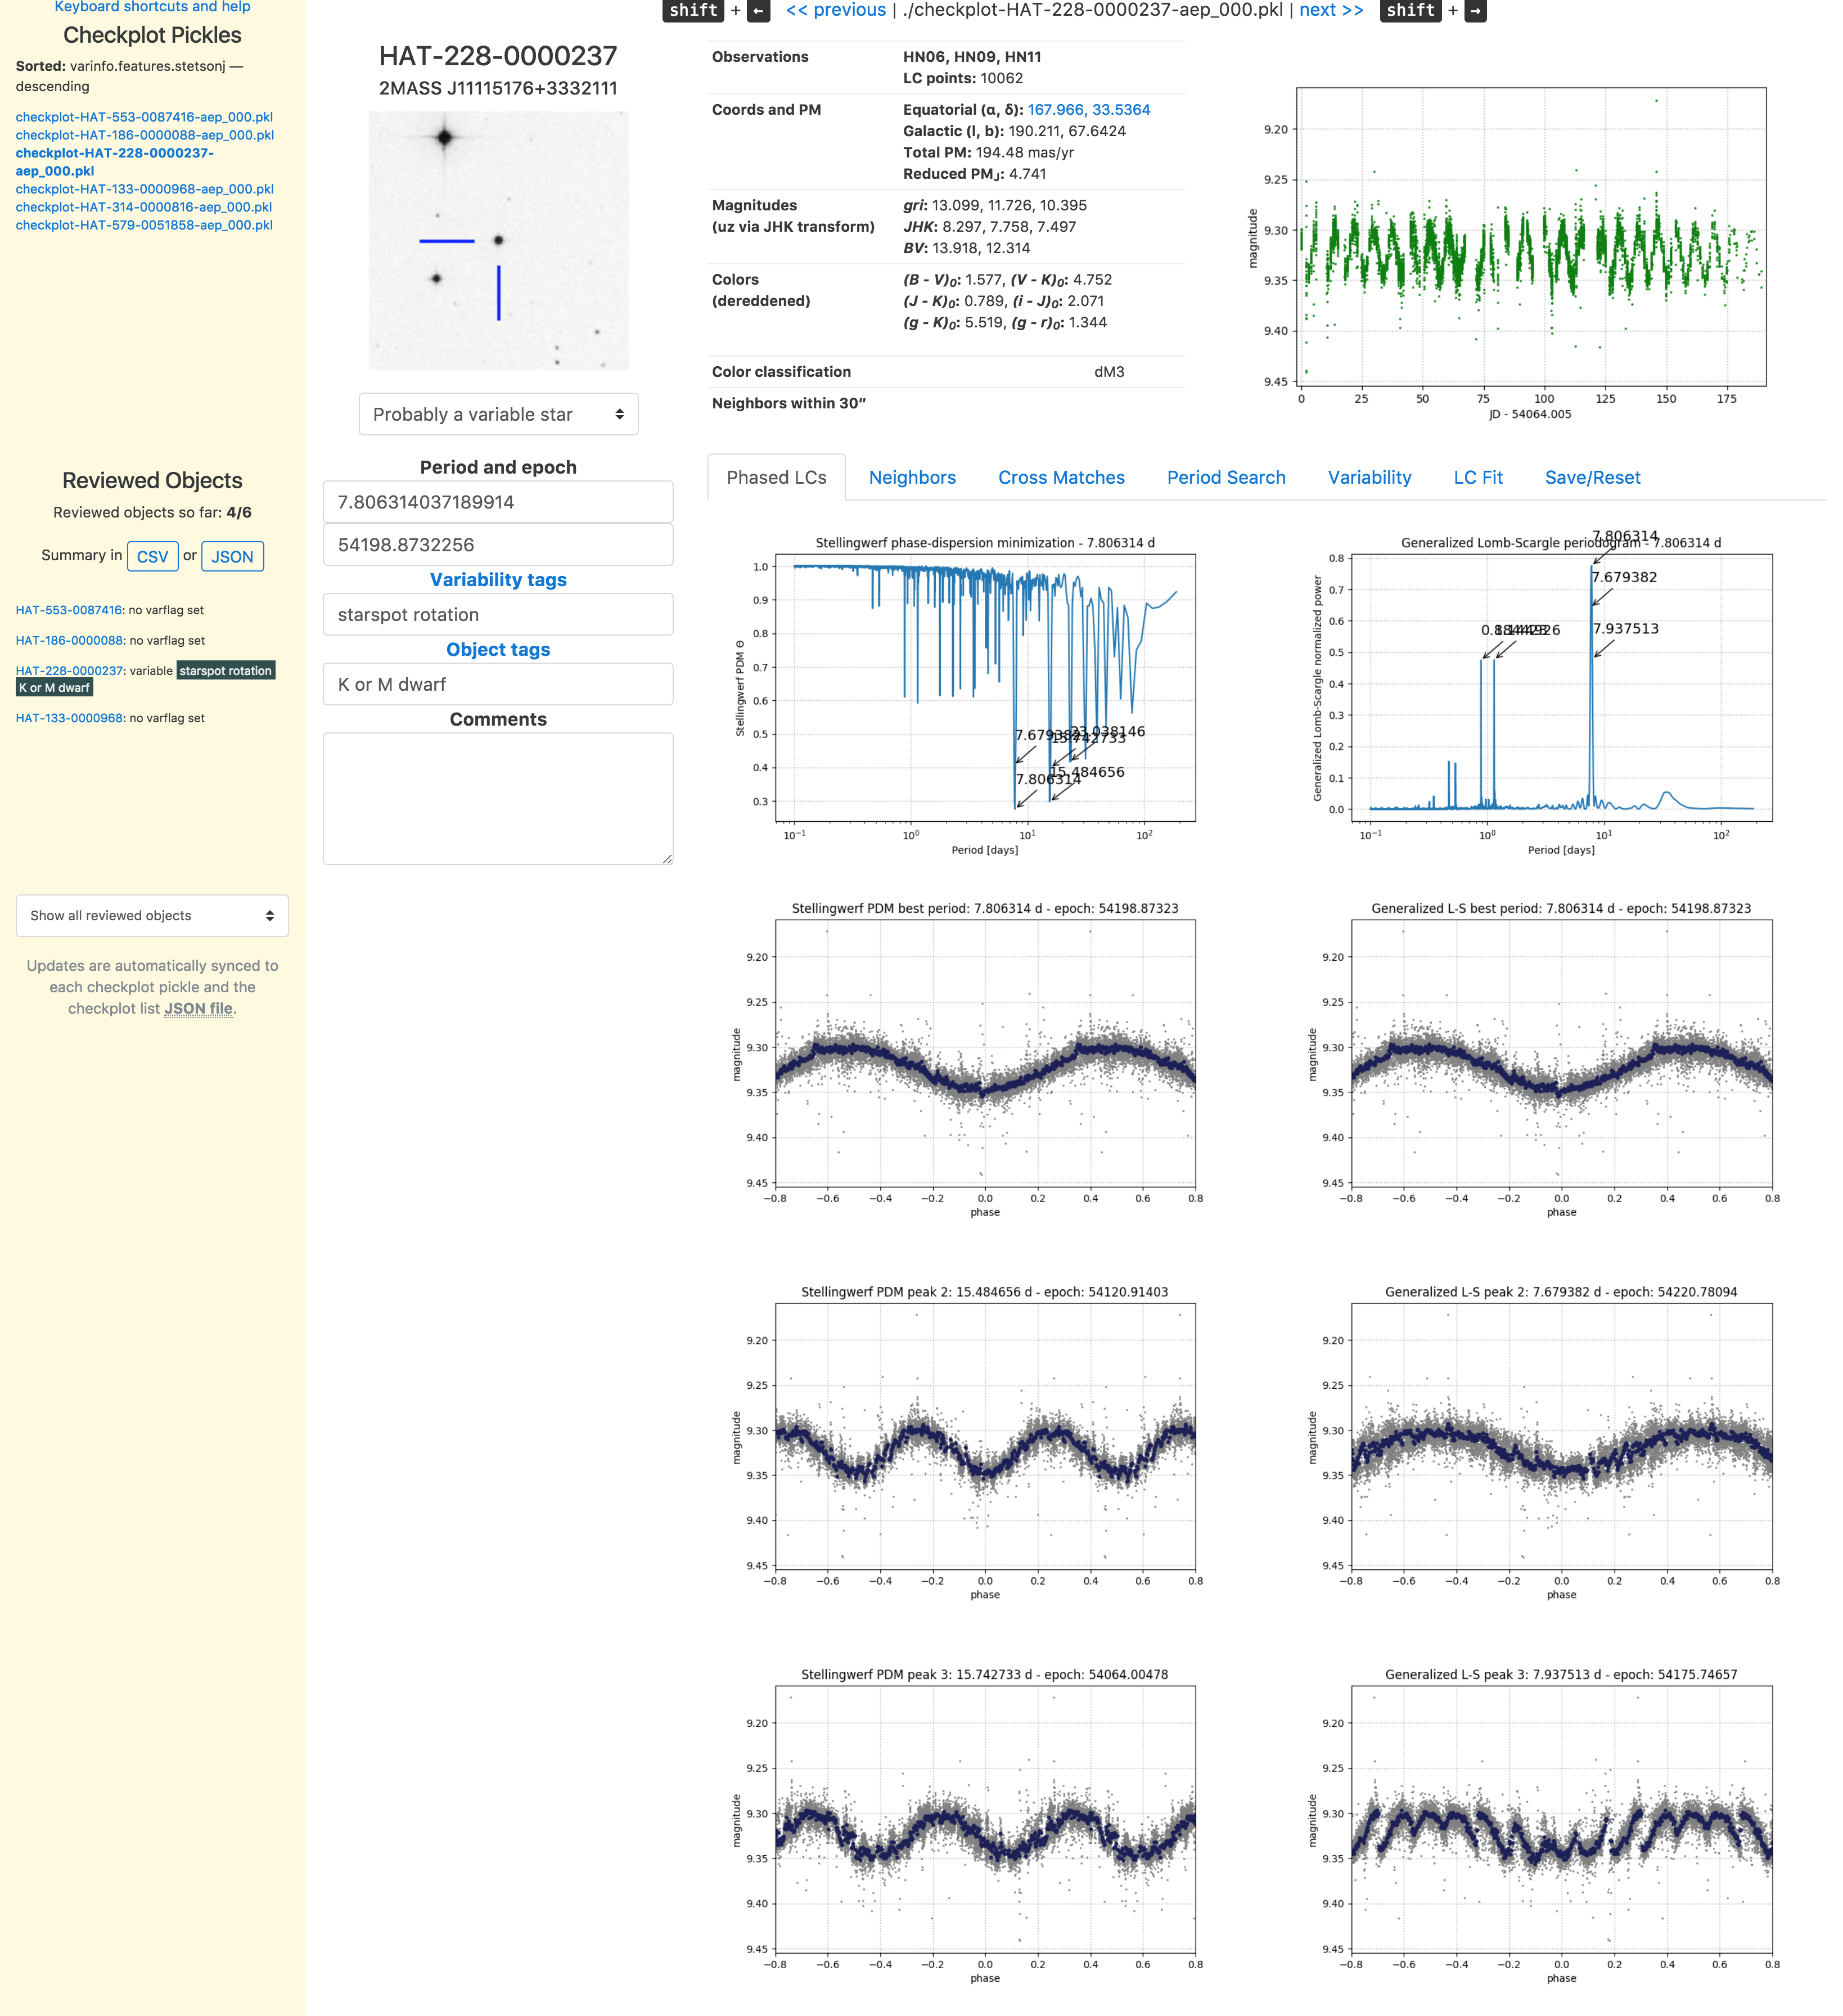

In [23]:
from IPython.display import Image
Image('127.0.0.1_5225_.png')

Going through the items in the `checkplotserver` interface:

- _Top-left_: a list of the checkplot pickles loaded from the checkplot-filelist.json file. Click on any file to jump to it. Whenever you move from one checkplot to another, the app will automatically save all changes you made (if any) to the previous checkplot pickle.

- _Top_: a navigation bar with "prev" and "next" links to move through the checkplot list. A brief help and keyboard shortcut list is available by clicking on the "See more keyboard shortcuts and help" link. The keyboard shortcuts allow quick tagging, selection of best periods and epochs, and movement through the checkplot list. A list of these is given below.

- _Bottom-left_: a list of objects that have been reviewed as you move through the checkplot list. This is automatically updated whenever you move from one checkplot to another, and contains a quick overview of objects, their variability and object type tags, and whether or not they were noted as actually variable, based on your inputs. The list can be exported to CSV or JSON by clicking the appropriate links.

- _Center-left_: the finder chart for the object, and input boxes for flagging this object as a variable, its best period and epoch as chosen from the grid of the phased light curve plots on the center-right, input boxes for variability tags and object tags, and a text box for free-form comments. The tag input boxes have a list of default tags that can be chosen from by clicking on the respective "Variability tags" or "Object tags" links, but you can type in your own tags as appropriate, separated by commas. You can export the currently loaded checkplot pickle to a PNG by clicking the "Save this object to a PNG" link. The saved PNG image's full path will appear below.

- _Center-top_: basic object information from the light curve, including magnitudes, colors, and proper motion. The panel on the right shows the unphased light curve of the object, using the time and magnitude columns that you selected when you made the checkplot pickle.

- _Center-right_: a grid of plots showing the periodograms (top panels) and phased light curve plots using the best 3 periods in the periodogram (next 3 rows; the best overall period found by the period-search is highlighted), for each period-search method in separate columns. Hovering over and clicking a phased light curve in this grid will select the associated period and epoch as the best period and epoch for this object and populate these respective input boxes on the left.

Reviewing many checkplots for many light curves should be fairly straightforward using this interface. For fast movement and tagging, extensive keyboard shortcuts are supported. Click on the `shortcuts` link at the top left to see these. 

NOTE: The `checkplotserver` webapp is under heavy development. Basic functionality such as loading, reviewing, tagging objects, adding comments, etc. works fine. Lots of the `astrobase` tools are being added to the interface so they can run directly from there (e.g. period-finding, LC fitting, masking signals, etc.) This is expected to be completed fairly soon.

## Exporting results from the `checkplotserver`

All of the progress and input information entered into the `checkplotserver` interface is available for export as CSV or JSON. These are fairly standard format files that can then be incorporated into the next stage of a variability classification pipeline. Each object's checkplot information can also be exported to a PNG for quick review.